## 查看dcm文件

(512, 512)


Text(0.5, 1.0, 'UID:1.3.6.1.4.1.14519.5.2.1.6655.2359.911257607240619696148712587012')

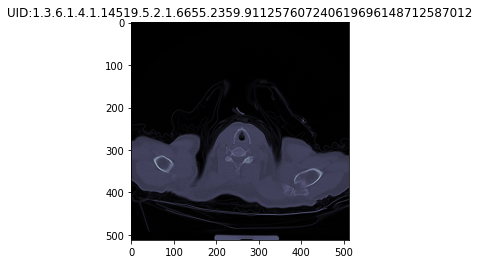

In [1]:
import pydicom
import matplotlib.pyplot as plt

im = pydicom.read_file('manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0001/04-04-2007-NA-Chest-07990/2.000000-5mm-40805/1-01.dcm')

# 获取 UID
uid = im.SOPInstanceUID

# 获取像素矩阵
img_arr = im.pixel_array
# 打印矩阵大小
print(img_arr.shape)

# 绘制图像
plt.imshow(img_arr,cmap=plt.cm.bone)
plt.title("UID:{}".format(uid))

## dcm文件与xml文件配对

In [2]:
# 查看 A0001 号数据的图像文件和xml标注文件
import os

# 查看指定目录下所有的dcm文件名
dcm_file=[]
for root, dirs, files in os.walk('manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0001'):
    for file in files:
        file_path = os.path.join(root, file)
        if 'dcm' in file_path:
            dcm_file.append(file_path)
print(dcm_file[0])

# 查看指定目录下所有的dcm文件的 SOP Instance UID
dcm_file_uid=[]
for dcm in dcm_file:
    im=pydicom.read_file(dcm)
    dcm_uid=im.SOPInstanceUID
    dcm_file_uid.append(dcm_uid)
print(dcm_file_uid[0])

# 查看指定Annotation的指定目录下所有的XML文件
xml_file=[]
for root, dirs, files in os.walk('Lung-PET-CT-Dx-Annotations-XML-Files-rev12222020/Annotation/A0001'):
    for file in files:
        file_path = os.path.join(root, file)      
        if 'xml' in file_path:
            xml_file.append(file_path)
print(xml_file[0])

manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0001\04-04-2007-NA-Chest-07990\2.000000-5mm-40805\1-01.dcm
1.3.6.1.4.1.14519.5.2.1.6655.2359.911257607240619696148712587012
Lung-PET-CT-Dx-Annotations-XML-Files-rev12222020/Annotation/A0001\1.3.6.1.4.1.14519.5.2.1.6655.2359.102500633407588554681658808214.xml


In [3]:
# 从dcm_file找出“SOP Instance UID”与xml_file一致的文件
to_select_dcm = []
for xml in xml_file:
    xml_file_name = xml[66:-4]
    if xml_file_name in dcm_file_uid:
        idx = dcm_file_uid.index(xml_file_name)
        to_select_dcm.append(dcm_file[idx])
to_select_dcm[:5]

['manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0001\\04-04-2007-NA-Chest-07990\\3.000000-5mm-41315\\1-18.dcm',
 'manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0001\\04-04-2007-NA-Chest-07990\\3.000000-5mm-41315\\1-22.dcm',
 'manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0001\\04-04-2007-NA-Chest-07990\\2.000000-5mm-40805\\1-19.dcm',
 'manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0001\\04-04-2007-NA-Chest-07990\\2.000000-5mm-40805\\1-22.dcm',
 'manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0001\\04-04-2007-NA-Chest-07990\\2.000000-5mm-40805\\1-13.dcm']

### 预览图像

In [4]:
# 我们取第一张配对好的 dcm图片 和 XML标注文件
im, xml = to_select_dcm[0], xml_file[0]

(512, 512)


Text(0.5, 1.0, 'UID:1.3.6.1.4.1.14519.5.2.1.6655.2359.102500633407588554681658808214')

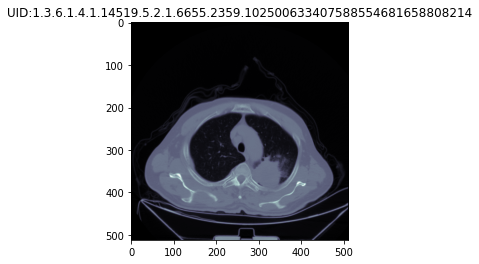

In [5]:
# 查看dcm图片文件

im = pydicom.read_file(im)

# 获取 UID
uid = im.SOPInstanceUID
# 获取像素矩阵
img_arr = im.pixel_array
# 打印矩阵大小
print(img_arr.shape)

# 绘制图像
plt.imshow(img_arr,cmap=plt.cm.bone)
plt.title("UID:{}".format(uid))

In [6]:
# 从XML文件获取bounding box信息
import xml.etree.ElementTree as ET

def get_labelFromXml(xml_file):     
    label=[]
    bbox_list=[]

    an_file = open(xml_file, encoding='utf-8')
    tree=ET.parse(an_file)
    root = tree.getroot()
    for object in root.findall('object'):    
        cancer_type=object.find('name').text.upper()
        xmin=object.find('bndbox').find('xmin').text
        xmax=object.find('bndbox').find('xmax').text
        ymin=object.find('bndbox').find('ymin').text
        ymax=object.find('bndbox').find('ymax').text

        if int(xmin)==0 or int(xmax)==0 or int(ymin)==0 or int(ymax)==0:
            pass
        elif int(xmin)==int(xmax) or int(ymin)==int(ymax):
            pass
        else:
            bbox=[int(xmin),int(ymin),int(xmax),int(ymax)]
            bbox_list.append(bbox)
            label.append(cancer_type)
    return bbox_list,label

In [7]:
# 取第1组标注框和类别
bbox, label = get_labelFromXml(xml)
bbox, label = bbox[0], label[0]  # 一张dcm图片可能对应多个标注框，这里取第1个

Text(298, 322, 'A')

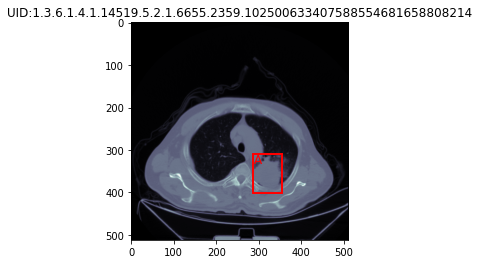

In [8]:
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

fig = plt.imshow(img_arr,cmap=plt.cm.bone)
plt.title("UID:{}".format(uid))

fig.axes.add_patch(bbox_to_rect(bbox, 'red'))
fig.axes.text(bbox[0]+12, bbox[1]+12, label,
                      va='center', ha='center', fontsize=12, color='red')